In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

# Getting dataset ready

In [2]:
def get_npy_file_paths(directory):
    return sorted(glob.glob(os.path.join(directory, "*.npy")))

# load file paths 
lr_dir = "/kaggle/input/dataset-3a/Dataset/LR"  
hr_dir = "/kaggle/input/dataset-3a/Dataset/HR"
lr_path =  get_npy_file_paths(lr_dir)
hr_path = get_npy_file_paths(hr_dir)


In [3]:
lr_path_tr,lr_path_test = train_test_split(lr_path,train_size=0.9, shuffle=True,random_state=42)
hr_path_tr,hr_path_test = train_test_split(hr_path,train_size=0.9, shuffle=True,random_state=42)

In [13]:
lr_mean= torch.tensor([0.0615])
lr_std=torch.tensor([0.1170])
hr_mean= torch.tensor([0.0615])
hr_std=torch.tensor([0.1169])

In [4]:
# custom dataset class
class SRDataset(Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform

    def __len__(self):
        return len(self.lr_path)

    def __getitem__(self, idx):
        lr = np.load(self.lr_path[idx]).astype(np.float32)  # Low-resolution image
        hr = np.load(self.hr_path[idx]).astype(np.float32)  # High-resolution image

        if self.transform:
            lr = self.transform(torch.tensor(lr, dtype=torch.float32))  
            hr = self.transform(torch.tensor(hr, dtype=torch.float32))
        return lr, hr

# Define transforms for normalization (-1 to 1 range)
transform = transforms.Compose([
    # transforms.Normalize(mean=[lr_mean], std=[lr_std])
])


In [5]:
# Loading  dataset

dataset_train = SRDataset(lr_path_tr, hr_path_tr, transform=transform)
dataset_test = SRDataset(lr_path_test,hr_path_test,transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [33]:

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        return x + self.bn2(self.conv2(self.prelu(self.bn1(self.conv1(x)))))

class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()

        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.upsample = nn.Sequential(
        nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor=2),  # Only ONE upsampling layer (as we want only 2X upscaling)
        nn.PReLU()
        )

        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4)
        # self.tanh = nn.Tanh()

    def forward(self, x):
        x1 = self.prelu(self.conv1(x))
        x2 = self.res_blocks(x1)
        x3 = self.bn2(self.conv2(x2)) + x1
        x4 = self.upsample(x3)
        return torch.clamp(self.conv3(x4),0,1)
        # return self.tanh(self.conv3(x4))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Training without Perceptual loss

In [34]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss functions
criterion_gan = nn.BCEWithLogitsLoss()  # For discriminator
criterion_pixel = nn.MSELoss()          # Pixel-wise loss

optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    # Training Phase
    generator.train()
    discriminator.train()
    G_loss = 0.0
    D_loss = 0.0
    for lr, hr in tqdm(train_dataloader):
        lr, hr = lr.to(device), hr.to(device)

        # Train Generator
        fake_hr = generator(lr)
        # fake_hr = torch.clamp(fake_hr,0,1)
        loss_pixel = criterion_pixel(fake_hr, hr)
        optimizer_g.zero_grad()
        loss_pixel.backward()
        optimizer_g.step()
        G_loss += loss_pixel.item()

        # Train Discriminator
        real_pred = discriminator(hr)
        fake_pred = discriminator(fake_hr.detach())

        loss_real = criterion_gan(real_pred, torch.ones_like(real_pred))
        loss_fake = criterion_gan(fake_pred, torch.zeros_like(fake_pred))

        loss_d = (loss_real + loss_fake) / 2
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        D_loss += loss_d.item()

    # Evaluation Phase (on test dataset)
    generator.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr, hr in test_dataloader:
            lr, hr = lr.to(device), hr.to(device)
            fake_hr = generator(lr)
            loss_pixel = criterion_pixel(fake_hr, hr)
            test_loss += loss_pixel.item()

    test_loss /= len(test_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, G Loss: {G_loss/len(train_dataloader)}, D Loss: {D_loss/len(train_dataloader)}, Test Loss: {test_loss:.4f}")


100%|██████████| 282/282 [02:26<00:00,  1.92it/s]


Epoch 1/10, G Loss: 0.0009605452934971925, D Loss: 0.5358185639195409, Test Loss: 0.0002


100%|██████████| 282/282 [02:10<00:00,  2.16it/s]


Epoch 2/10, G Loss: 0.0002342788338993927, D Loss: 0.5273569634197451, Test Loss: 0.0002


100%|██████████| 282/282 [02:10<00:00,  2.16it/s]


Epoch 3/10, G Loss: 0.00018176844742224247, D Loss: 0.5033254773481518, Test Loss: 0.0002


100%|██████████| 282/282 [02:10<00:00,  2.16it/s]


Epoch 4/10, G Loss: 0.00014853527664073995, D Loss: 0.503292091560702, Test Loss: 0.0001


100%|██████████| 282/282 [02:10<00:00,  2.16it/s]


Epoch 5/10, G Loss: 0.0001283473669229726, D Loss: 0.5032424764007541, Test Loss: 0.0001


100%|██████████| 282/282 [02:11<00:00,  2.14it/s]


Epoch 6/10, G Loss: 0.00011605944573538252, D Loss: 0.5032824383559802, Test Loss: 0.0001


100%|██████████| 282/282 [02:11<00:00,  2.15it/s]


Epoch 7/10, G Loss: 0.00011489136097147725, D Loss: 0.5032224858060796, Test Loss: 0.0002


100%|██████████| 282/282 [02:11<00:00,  2.15it/s]


Epoch 8/10, G Loss: 0.00011160651607135912, D Loss: 0.5032199046290513, Test Loss: 0.0001


100%|██████████| 282/282 [02:11<00:00,  2.14it/s]


Epoch 9/10, G Loss: 0.00010871954718629453, D Loss: 0.5032132716043621, Test Loss: 0.0001


100%|██████████| 282/282 [02:11<00:00,  2.14it/s]


Epoch 10/10, G Loss: 9.55787941069154e-05, D Loss: 0.5032105972158148, Test Loss: 0.0001


In [35]:
# save model
generator.eval()
checkpoint = '/kaggle/working/Generator_without_perc.pth'
torch.save(generator.state_dict(),checkpoint)

In [36]:
# Load the pretained model
generator = Generator()
generator.load_state_dict(torch.load(checkpoint,map_location=device))

<ipython-input-36-c09f412758dd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(checkpoint,map_location=device))


<All keys matched successfully>

In [37]:
#  code for evaluating metric
# MSE loss
def mse(hr, sr):
    return torch.mean((hr - sr) ** 2)
# PSNR 
def psnr(hr, sr):
    mse_value = mse(hr, sr)
    if mse_value == 0:
        return float('inf')  # No difference between images
    max_pixel = 1.0  # Assuming 8-bit images
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))
# SSIM
def calculate_ssim(hr, sr):
    return ssim(hr, sr, data_range=hr.max() - hr.min())


In [38]:
def eval_metric(dataset):
    device = 'cpu'
    generator.eval()
    generator.to(device)
    avg_mse=0.0
    avg_psnr=0.0
    avg_ssim=0.0
    for idx in tqdm(range(len(dataset))):
        hr_img = dataset.__getitem__(idx)[1].squeeze()
        lr_img = dataset.__getitem__(idx)[0].unsqueeze(0)
        fake_hr_img =  generator(lr_img).detach().numpy().squeeze()
        avg_mse += mse(hr_img,fake_hr_img)
        avg_psnr += psnr(hr_img,fake_hr_img)
        avg_ssim += calculate_ssim(hr_img.detach().numpy(),fake_hr_img)
    print(f'Average MSE Loss : {avg_mse/len(dataset)}')
    print(f'Average PSNR : {avg_psnr/len(dataset)}')
    print(f'Average SSIM : {avg_ssim/len(dataset)}')

eval_metric(dataset_test)

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]

Average MSE Loss : 8.524374425178394e-05
Average PSNR : 40.7272834777832
Average SSIM : 0.9463378295867872


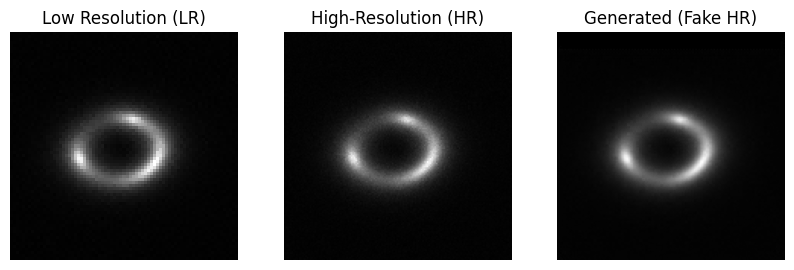

MSE Loss : 8.736875315662473e-05 || PSNR : 40.5864372253418 || SSIM : 0.9482446604991838


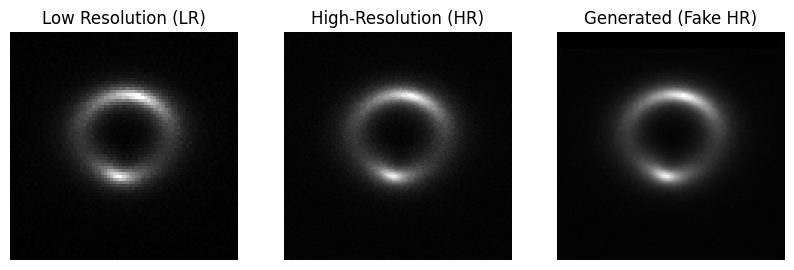

MSE Loss : 9.843838779488578e-05 || PSNR : 40.068355560302734 || SSIM : 0.9356154865372558


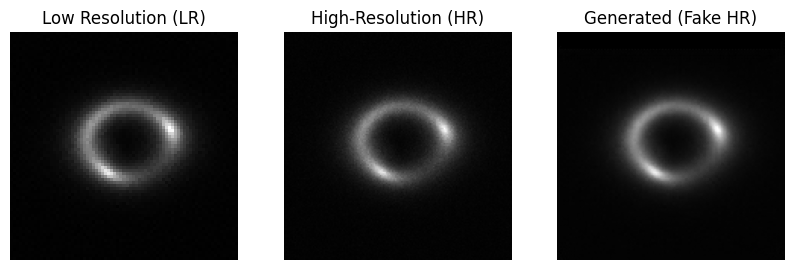

MSE Loss : 8.470929606119171e-05 || PSNR : 40.7206916809082 || SSIM : 0.9461293042174621


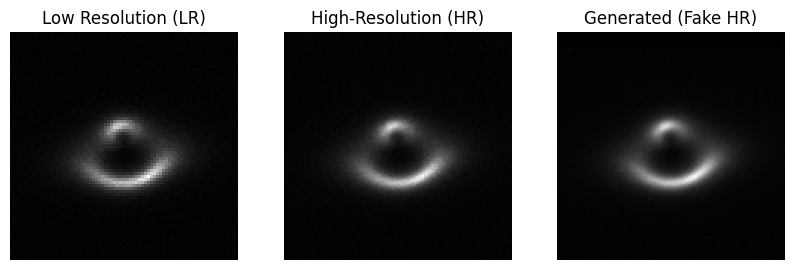

MSE Loss : 8.406207052757964e-05 || PSNR : 40.753997802734375 || SSIM : 0.9432706510415301


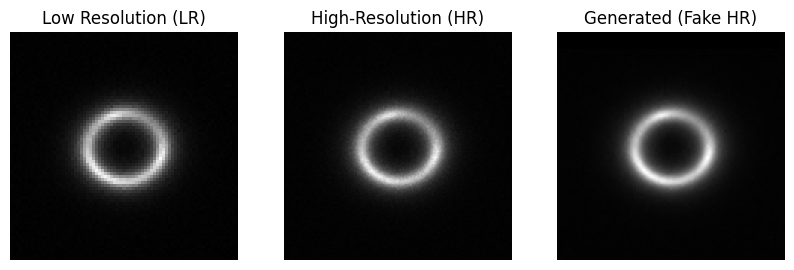

MSE Loss : 9.93747598840855e-05 || PSNR : 40.02723693847656 || SSIM : 0.9520255794538829


In [56]:
def visualize(model,idx,dataset_test):
    hr_img = dataset_test.__getitem__(idx)[1].squeeze()
    lr_img = dataset_test.__getitem__(idx)[0].unsqueeze(0)
    fake_hr_img =  torch.clamp(model(lr_img),0,1).detach().numpy().squeeze()
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # plot LR Image
    axes[0].imshow(lr_img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[0].set_title("Low Resolution (LR)")
    axes[0].axis("off")
    
    # Plot HR image
    axes[1].imshow(hr_img.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[1].set_title("High-Resolution (HR)")
    axes[1].axis("off")
    
    # Plot Fake HR image
    axes[2].imshow(fake_hr_img.squeeze(), cmap='gray')
    axes[2].set_title("Generated (Fake HR)")
    axes[2].axis("off")
    
    # Show the images
    plt.show()
    print(f'MSE Loss : {mse(hr_img,fake_hr_img)}',end=' || ')
    print(f'PSNR : {psnr(hr_img,fake_hr_img)}',end=' || ')
    print(f'SSIM : {calculate_ssim(hr_img.detach().numpy(),fake_hr_img)}')


samples = np.random.randint(0,len(dataset_test)-1,5)
for idx in samples:
    visualize(generator,idx,dataset_test)

# Training With Perceptual loss 

In [44]:
generator_perc = Generator().to(device)
discriminator_perc = Discriminator().to(device)

# Define loss functions
criterion_gan = nn.BCEWithLogitsLoss()  # For discriminator_perc
criterion_pixel = nn.MSELoss()          # Pixel-wise loss

optimizer_g = torch.optim.Adam(generator_perc .parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator_perc.parameters(), lr=1e-4)

# Import VGG19 for perceptual loss
from torchvision.models import vgg19
# Load pre-trained VGG19 model
vgg = vgg19(pretrained=True).features.to(device).eval()

# Freeze VGG19 parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define perceptual loss function
def perceptual_loss(fake_img, real_img):
    fake_features = vgg(fake_img.repeat(1, 3, 1, 1))
    real_features = vgg(real_img.repeat(1, 3, 1, 1))
    return F.mse_loss(fake_features, real_features)

num_epochs = 10
lambda_adv = 0.001  # Weight for adversarial loss
lambda_perc = 0.006  # Weight for perceptual loss

for epoch in range(num_epochs):
    # Training Phase
    generator_perc.train()
    discriminator_perc.train()
    G_loss = 0.0
    D_loss = 0.0

    for lr, hr in tqdm(train_dataloader):
        lr, hr = lr.to(device), hr.to(device)

        # Generate Fake HR Image
        fake_hr = generator_perc (lr)

        # Compute Perceptual Loss
        loss_perc = perceptual_loss(fake_hr, hr)

        # Compute Adversarial Loss for Generator
        fake_pred = discriminator_perc(fake_hr)
        loss_adv = criterion_gan(fake_pred, torch.ones_like(fake_pred))

        # Compute Pixel-wise Loss (MSE)
        loss_pixel = criterion_pixel(fake_hr, hr)

        # Total Generator Loss
        loss_g = loss_pixel + lambda_adv * loss_adv + lambda_perc * loss_perc

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        G_loss += loss_g.item()

        # Train Discriminator
        real_pred = discriminator_perc(hr)
        fake_pred = discriminator_perc(fake_hr.detach())

        loss_real = criterion_gan(real_pred, torch.ones_like(real_pred))
        loss_fake = criterion_gan(fake_pred, torch.zeros_like(fake_pred))

        loss_d = (loss_real + loss_fake) / 2  # Discriminator Loss

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        D_loss += loss_d.item()

    # Evaluation Phase (on test dataset)
    generator_perc.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr, hr in test_dataloader:
            lr, hr = lr.to(device), hr.to(device)
            fake_hr = generator_perc(lr)
            fake_hr = torch.clamp(fake_hr, 0, 1)
            loss_pixel = criterion_pixel(fake_hr, hr)
            test_loss += loss_pixel.item()

    test_loss /= len(test_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, G Loss: {G_loss/len(train_dataloader):.6f}, "
          f"D Loss: {D_loss/len(train_dataloader):.6f}, Test Loss: {test_loss:.4f}")

100%|██████████| 282/282 [03:14<00:00,  1.45it/s]


Epoch 1/10, G Loss: 0.001907, D Loss: 0.524056, Test Loss: 0.0003


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 2/10, G Loss: 0.001024, D Loss: 0.507779, Test Loss: 0.0002


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 3/10, G Loss: 0.000914, D Loss: 0.503441, Test Loss: 0.0001


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 4/10, G Loss: 0.000958, D Loss: 0.545349, Test Loss: 0.0005


100%|██████████| 282/282 [03:09<00:00,  1.48it/s]


Epoch 5/10, G Loss: 0.000908, D Loss: 0.677519, Test Loss: 0.0001


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 6/10, G Loss: 0.000869, D Loss: 0.693145, Test Loss: 0.0001


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 7/10, G Loss: 0.000847, D Loss: 0.693142, Test Loss: 0.0001


100%|██████████| 282/282 [03:08<00:00,  1.50it/s]


Epoch 8/10, G Loss: 0.000889, D Loss: 0.633246, Test Loss: 0.0002


100%|██████████| 282/282 [03:08<00:00,  1.49it/s]


Epoch 9/10, G Loss: 0.000855, D Loss: 0.693147, Test Loss: 0.0001


100%|██████████| 282/282 [03:09<00:00,  1.49it/s]


Epoch 10/10, G Loss: 0.000840, D Loss: 0.693147, Test Loss: 0.0001


In [54]:
generator_perc.eval()
torch.save(generator_perc.state_dict(),'/kaggle/working/Generator_perc.pth')

In [51]:
generator_perc = Generator()
generator_perc.load_state_dict(torch.load('/kaggle/working/Generator_perc.pth',map_location=device))

<ipython-input-51-1a4f3c787643>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_perc.load_state_dict(torch.load('/kaggle/working/Generator_perc.pth',map_location=

<All keys matched successfully>

In [52]:
def eval_metric(dataset):
    generator_perc.eval()
    device='cpu'
    generator_perc.to(device)
    avg_mse=0.0
    avg_psnr=0.0
    avg_ssim=0.0
    for idx in tqdm(range(len(dataset))):
        hr_img = dataset.__getitem__(idx)[1].squeeze()
        lr_img = dataset.__getitem__(idx)[0].unsqueeze(0)
        lr_img = lr_img.to(device)
        fake_hr_img =  torch.clamp(generator_perc(lr_img),0,1).detach().numpy().squeeze()
        avg_mse += mse(hr_img,fake_hr_img)
        avg_psnr += psnr(hr_img,fake_hr_img)
        avg_ssim += calculate_ssim(hr_img.detach().numpy(),fake_hr_img)
    print(f'Average MSE Loss : {avg_mse/len(dataset)}')
    print(f'Average PSNR : {avg_psnr/len(dataset)}')
    print(f'Average SSIM : {avg_ssim/len(dataset)}')

eval_metric(dataset_test)

100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]

Average MSE Loss : 0.00013254689110908657
Average PSNR : 38.81459426879883
Average SSIM : 0.9064703193686017


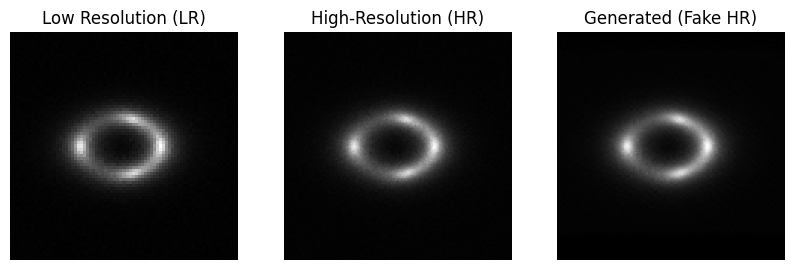

MSE Loss : 0.00012797466479241848 || PSNR : 38.92876052856445 || SSIM : 0.9133798956345008


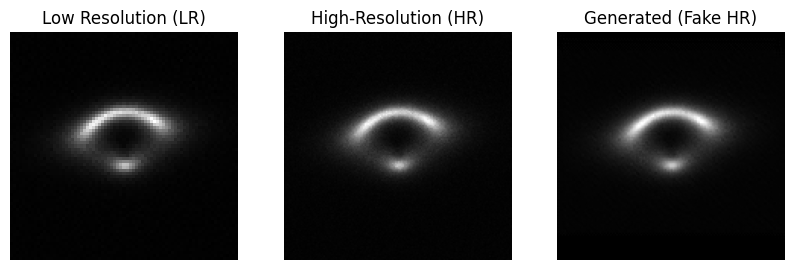

MSE Loss : 0.00013066870451439172 || PSNR : 38.83828353881836 || SSIM : 0.905094401751369


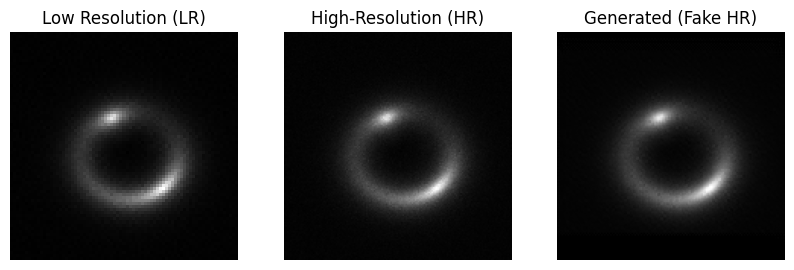

MSE Loss : 0.0001444599765818566 || PSNR : 38.402523040771484 || SSIM : 0.8867079353105151


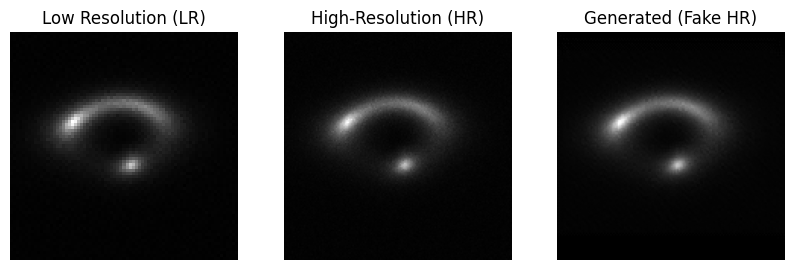

MSE Loss : 0.00010728545748861507 || PSNR : 39.6945915222168 || SSIM : 0.9063697980277033


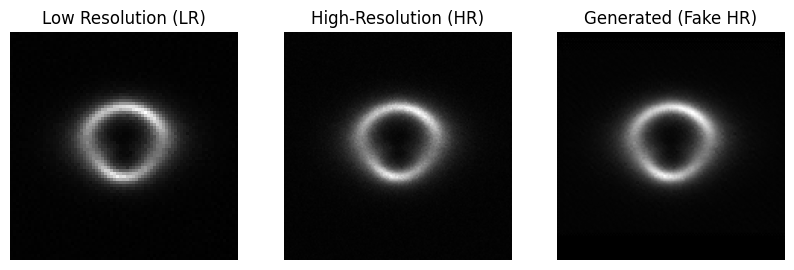

MSE Loss : 0.0001714938844088465 || PSNR : 37.65751266479492 || SSIM : 0.8991111197140942


In [57]:
samples = np.random.randint(0,len(dataset_test)-1,5)
for idx in samples:
    visualize(generator_perc,idx,dataset_test)